<a href="https://colab.research.google.com/github/hammaad2002/Solar-Irradiance-Forecasting/blob/main/lstm_model_for_solar_irradiance_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!git clone https://github.com/hammaad2002/Solar-Irradiance-Forecasting.git
!pip install torchmetrics

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# Assuming your DataFrame is named 'df'
desired_starting_row = 3
df = pd.read_csv('/kaggle/working/Solar-Irradiance-Forecasting/Solar Irradiance Dataset/2017Solar.csv', skiprows=desired_starting_row - 1)
df

,Year,Month,Day,Hour,Minute,GHI,Temperature,Dew Point,Relative Humidity,Pressure,Wind Direction,Wind Speed,Precipitable Water
0,2017,1,1,0,0,0,10.6,-17.4,12.29,949,103,0.7,0.7
1,2017,1,1,0,15,0,10.5,-17.4,12.37,949,107,0.7,0.7
2,2017,1,1,0,30,0,10.4,-17.4,12.45,949,111,0.7,0.7
3,2017,1,1,0,45,0,10.2,-17.3,12.74,949,115,0.7,0.7
4,2017,1,1,1,0,0,10.1,-17.3,12.83,949,120,0.7,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,2017,12,31,22,45,0,11.2,-17.4,11.78,950,81,0.8,0.7
35036,2017,12,31,23,0,0,11.1,-17.4,11.86,950,85,0.8,0.7
35037,2017,12,31,23,15,0,11.0,-17.4,11.93,949,89,0.7,0.7
35038,2017,12,31,23,30,0,10.9,-17.4,12.01,949,94,0.7,0.7


In [ ]:
workingDf = df.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis = 1)
workingDf

,GHI,Temperature,Dew Point,Relative Humidity,Pressure,Wind Direction,Wind Speed,Precipitable Water
0,0,10.6,-17.4,12.29,949,103,0.7,0.7
1,0,10.5,-17.4,12.37,949,107,0.7,0.7
2,0,10.4,-17.4,12.45,949,111,0.7,0.7
3,0,10.2,-17.3,12.74,949,115,0.7,0.7
4,0,10.1,-17.3,12.83,949,120,0.7,0.7
...,...,...,...,...,...,...,...,...
35035,0,11.2,-17.4,11.78,950,81,0.8,0.7
35036,0,11.1,-17.4,11.86,950,85,0.8,0.7
35037,0,11.0,-17.4,11.93,949,89,0.7,0.7
35038,0,10.9,-17.4,12.01,949,94,0.7,0.7


In [ ]:
columns = workingDf.columns.tolist()
columns[0], columns[-1] = columns[-1], columns[0]
workingDf = workingDf[columns]
workingDf

,Precipitable Water,Temperature,Dew Point,Relative Humidity,Pressure,Wind Direction,Wind Speed,GHI
0,0.7,10.6,-17.4,12.29,949,103,0.7,0
1,0.7,10.5,-17.4,12.37,949,107,0.7,0
2,0.7,10.4,-17.4,12.45,949,111,0.7,0
3,0.7,10.2,-17.3,12.74,949,115,0.7,0
4,0.7,10.1,-17.3,12.83,949,120,0.7,0
...,...,...,...,...,...,...,...,...
35035,0.7,11.2,-17.4,11.78,950,81,0.8,0
35036,0.7,11.1,-17.4,11.86,950,85,0.8,0
35037,0.7,11.0,-17.4,11.93,949,89,0.7,0
35038,0.7,10.9,-17.4,12.01,949,94,0.7,0


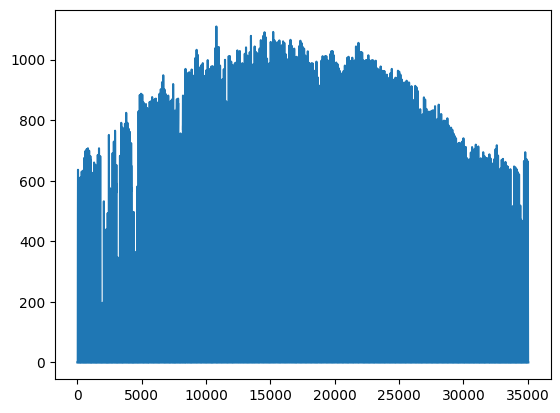

In [ ]:
target = workingDf['GHI']
target.plot()
plt.show()

In [ ]:
random_day = random.randint(1, 365)
random_day

43

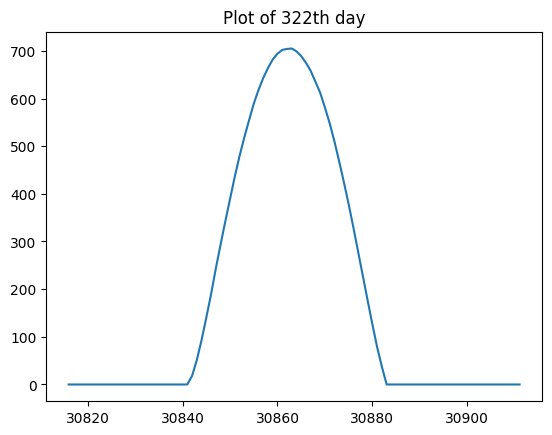

In [ ]:
random_day = random.randint(4, 365) # starting from 4th day so that I can write "th" in the title :)
target = workingDf['GHI'][(random_day-1)*96:(random_day*96)]
target.plot()
plt.title(str(f"Plot of {random_day}th day"))
plt.show()

In [ ]:
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(workingDf), columns=workingDf.columns)
df_normalized.head(10) # this normalizes the data in between range [0, 1]

,Precipitable Water,Temperature,Dew Point,Relative Humidity,Pressure,Wind Direction,Wind Speed,GHI
0,0.166667,0.291743,0.236287,0.122209,0.633333,0.286111,0.043860,0.0
1,0.166667,0.289908,0.236287,0.123159,0.633333,0.297222,0.043860,0.0
2,0.166667,0.288073,0.236287,0.124109,0.633333,0.308333,0.043860,0.0
3,0.166667,0.284404,0.238397,0.127553,0.633333,0.319444,0.043860,0.0
4,0.166667,0.282569,0.238397,0.128622,0.633333,0.333333,0.043860,0.0
5,0.166667,0.280734,0.238397,0.129572,0.633333,0.344444,0.035088,0.0
6,0.166667,0.278899,0.238397,0.130641,0.633333,0.355556,0.035088,0.0
7,0.166667,0.277064,0.240506,0.132660,0.633333,0.366667,0.035088,0.0
8,0.166667,0.275229,0.240506,0.133729,0.633333,0.377778,0.035088,0.0
9,0.166667,0.273394,0.240506,0.134679,0.633333,0.394444,0.035088,0.0


In [ ]:
class simpleLSTM(nn.Module):
    def __init__(self, features = 8, prediction = 1, window = 288, horizon = 1):
        super(simpleLSTM, self).__init__()

        self.layer1 = nn.LSTM(input_size = 8, hidden_size = 128, 
                             num_layers = 1, bias = True, 
                             batch_first = True, dropout = 0.2)
        
        self.activation1 = nn.Tanh()
        
        self.layer2 = nn.LSTM(input_size = 128, hidden_size = 64,
                             num_layers = 1, bias = True,
                             batch_first = True, dropout = 0.2)

        self.activation2 = nn.Tanh()
        
        self.layer3 = nn.LSTM(input_size = 64, hidden_size = 32,
                             num_layers = 1, bias = True,
                             batch_first = True, dropout = 0.2)
        
        self.activation3 = nn.Tanh()
        
        self.layer4 = nn.Linear(in_features = 32, out_features = 1)
       
        self.activation4 = nn.GELU()
        
        self.drop = nn.Dropout(p=0.5)

        self.layer5 = nn.Linear(in_features = window, out_features = horizon)

        self.activation5 = nn.GELU()

    def forward(self, x):

        x = self.layer1(x)
        x = self.activation1(x[0])
        x = self.layer2(x)
        x = self.activation2(x[0])
        x = self.layer3(x)
        x = self.activation3(x[0])
        x = self.layer4(x)
        x = self.activation4(x)
        x = self.drop(x)
        x = x.transpose(1, 2)
        x = self.layer5(x)
        x = self.activation5(x)
        return x

In [ ]:
per_day_readings = 4 * 24
window_length = 3 * per_day_readings    # we want our model to look back at the data of 3 days
horizon = 1                             # and then predict the next 15 minute reading

In [ ]:
df = df_normalized.values
stride = 1
x = []
y = []
for i in tqdm(range(0, len(df) - window_length, stride)):
    x.append(df[i:window_length+i, : ]) #GHI included but its past values only
    y.append(df[window_length+i,-1])                  #next GHI value

  0%|          | 0/34752 [00:00<?, ?it/s]

In [ ]:
x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)

(34752, 288, 8)
(34752,)


In [ ]:
x[45]

array([[0.36111111, 0.55779817, 0.50843882, ..., 0.71388889, 0.09649123,
        0.56176736],
       [0.36111111, 0.56330275, 0.50632911, ..., 0.73888889, 0.11403509,
        0.56988278],
       [0.36111111, 0.56697248, 0.50632911, ..., 0.76111111, 0.12280702,
        0.57348963],
       ...,
       [0.33333333, 0.46238532, 0.66666667, ..., 0.45277778, 0.13157895,
        0.50405771],
       [0.33333333, 0.46788991, 0.66666667, ..., 0.66944444, 0.13157895,
        0.52569883],
       [0.33333333, 0.47522936, 0.66666667, ..., 0.88888889, 0.14035088,
        0.54102795]])

In [ ]:
y[44]

0.5410279531109107

In [ ]:
# splitting our dataset into two parts one will be training set and the other will be testing set
# Lets store last 5 days as our test set
x_train = x[:-per_day_readings*5]
y_train = y[:-per_day_readings*5]
x_test  = x[len(y) - per_day_readings*5:]
y_test  = y[len(y) - per_day_readings*5:]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(34272, 288, 8)
(34272,)
(480, 288, 8)
(480,)


In [ ]:
# finding the device of our environment
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

In [ ]:
# converting our dataset to pytorch tensors for forwarding passing
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

In [ ]:
amp = True # If we want the model to be trained faster

In [ ]:
# Now we towards training the model
if amp:
    use_amp = True
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

In [ ]:
set_epochs = 50

In [ ]:
# initializing the model first before training
features = 8
prediction = 1

modelLSTM = simpleLSTM(features = features, prediction = prediction, 
                  window = window_length, horizon = horizon)

modelLSTM = modelLSTM.to(device)

In [ ]:
modelLSTM

simpleLSTM(
  (layer1): LSTM(8, 128, batch_first=True, dropout=0.2)
  (activation1): Tanh()
  (layer2): LSTM(128, 64, batch_first=True, dropout=0.2)
  (activation2): Tanh()
  (layer3): LSTM(64, 32, batch_first=True, dropout=0.2)
  (activation3): Tanh()
  (layer4): Linear(in_features=32, out_features=1, bias=True)
  (activation4): GELU(approximate='none')
  (drop): Dropout(p=0.5, inplace=False)
  (layer5): Linear(in_features=288, out_features=1, bias=True)
  (activation5): GELU(approximate='none')
)

In [ ]:
# Lets define loss function and optimizer
criterion = MeanAbsoluteError().to(device)                         # MAE
metricc = MeanAbsolutePercentageError().to(device)                 # MAPE metric
optimizer = optim.AdamW(modelLSTM.parameters(), lr=1e-4, weight_decay= 1e-5)               # Adam  TRY THIS : , 

num_epochs = set_epochs
batch_size = 128

loss_info_LSTM = []
metric_info_LSTM = []

for epoch in tqdm(range(num_epochs)):

    running_loss = 0.0                                             # MAE Loss
    running_metric = 0.0                                           # MAPE metric
    
    for i in tqdm(range(0, len(x_train_tensor), batch_size), desc=f"Epoch {epoch+1}"):

        # Get batch of inputs and targets
        batch_x = x_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        # Reshape input tensor
        batch_x = batch_x.view(-1, window_length, features)
        
        if amp:

            with torch.autocast(device_type= 'cuda', dtype=torch.float16, enabled=use_amp):
                # Forward pass
                outputs = modelLSTM(batch_x)
                
                if batch_size == 1:
                    loss = criterion(outputs.view(-1), torch.tensor([batch_y]))
                    metric = metricc(outputs.view(-1), torch.tensor([batch_y]))

                else:
                    loss = criterion(outputs.view(-1), batch_y)
                    metric = metricc(outputs.view(-1), batch_y)
            
            # Backward pass and optimization
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update() 

        else:       

            # Forward pass
            outputs = modelLSTM(batch_x)

            if batch_size == 1:
                loss = criterion(outputs.view(-1), torch.tensor([batch_y]))
                metric = metricc(outputs.view(-1), torch.tensor([batch_y]))

            else:
                loss = criterion(outputs.view(-1), batch_y)
                metric = metricc(outputs.view(-1), batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

        # Zero the parameter gradients
        optimizer.zero_grad(set_to_none=True)

        running_loss += loss.item()
        running_metric += metric.item()

    # Calculate epoch loss and metric
    epoch_loss = running_loss / (len(x_train) / batch_size)
    epoch_metric = running_metric / (len(x_train) / batch_size)
    loss_info_LSTM.append(epoch_loss)
    metric_info_LSTM.append(epoch_metric)
    print("-"*25, f"Epoch {epoch + 1}","-"*25)
    print(f"Epoch {epoch+1} MAE loss: {epoch_loss:.9f}")
    print(f"Epoch {epoch+1} MAPE metric: {epoch_metric:.9f}")

print("Training complete!")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 1 -------------------------
Epoch 1 MAE loss: 0.167718348
Epoch 1 MAPE metric: 18694.667873920


Epoch 2:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 2 -------------------------
Epoch 2 MAE loss: 0.088196543
Epoch 2 MAPE metric: 19434.048299268


Epoch 3:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 3 -------------------------
Epoch 3 MAE loss: 0.074596762
Epoch 3 MAPE metric: 14672.828679388


Epoch 4:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 4 -------------------------
Epoch 4 MAE loss: 0.067475474
Epoch 4 MAPE metric: 12152.233711193


Epoch 5:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 5 -------------------------
Epoch 5 MAE loss: 0.063303894
Epoch 5 MAPE metric: 10306.171820291


Epoch 6:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 6 -------------------------
Epoch 6 MAE loss: 0.060386019
Epoch 6 MAPE metric: 9040.597782082


Epoch 7:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 7 -------------------------
Epoch 7 MAE loss: 0.058518080
Epoch 7 MAPE metric: 8141.884271417


Epoch 8:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 8 -------------------------
Epoch 8 MAE loss: 0.057088553
Epoch 8 MAPE metric: 7391.079278456


Epoch 9:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 9 -------------------------
Epoch 9 MAE loss: 0.055150445
Epoch 9 MAPE metric: 6807.823106326


Epoch 10:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 10 -------------------------
Epoch 10 MAE loss: 0.053706653
Epoch 10 MAPE metric: 6456.641742895


Epoch 11:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 11 -------------------------
Epoch 11 MAE loss: 0.053235782
Epoch 11 MAPE metric: 6217.414349724


Epoch 12:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 12 -------------------------
Epoch 12 MAE loss: 0.052698953
Epoch 12 MAPE metric: 5963.932321757


Epoch 13:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 13 -------------------------
Epoch 13 MAE loss: 0.051827367
Epoch 13 MAPE metric: 5790.397434495


Epoch 14:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 14 -------------------------
Epoch 14 MAE loss: 0.051011124
Epoch 14 MAPE metric: 5682.949495032


Epoch 15:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 15 -------------------------
Epoch 15 MAE loss: 0.050313931
Epoch 15 MAPE metric: 5478.592684079


Epoch 16:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 16 -------------------------
Epoch 16 MAE loss: 0.049786081
Epoch 16 MAPE metric: 5388.044746805


Epoch 17:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 17 -------------------------
Epoch 17 MAE loss: 0.049628092
Epoch 17 MAPE metric: 5328.057608981


Epoch 18:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 18 -------------------------
Epoch 18 MAE loss: 0.048711105
Epoch 18 MAPE metric: 5244.451034190


Epoch 19:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 19 -------------------------
Epoch 19 MAE loss: 0.048187932
Epoch 19 MAPE metric: 5083.068388553


Epoch 20:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 20 -------------------------
Epoch 20 MAE loss: 0.047451233
Epoch 20 MAPE metric: 4996.009279623


Epoch 21:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 21 -------------------------
Epoch 21 MAE loss: 0.047351811
Epoch 21 MAPE metric: 4889.410191811


Epoch 22:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 22 -------------------------
Epoch 22 MAE loss: 0.046491111
Epoch 22 MAPE metric: 4795.428069926


Epoch 23:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 23 -------------------------
Epoch 23 MAE loss: 0.046315348
Epoch 23 MAPE metric: 4794.957535488


Epoch 24:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 24 -------------------------
Epoch 24 MAE loss: 0.046523390
Epoch 24 MAPE metric: 4742.412866188


Epoch 25:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 25 -------------------------
Epoch 25 MAE loss: 0.045753733
Epoch 25 MAPE metric: 4699.100735476


Epoch 26:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 26 -------------------------
Epoch 26 MAE loss: 0.046179975
Epoch 26 MAPE metric: 4688.501057259


Epoch 27:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 27 -------------------------
Epoch 27 MAE loss: 0.045915690
Epoch 27 MAPE metric: 4690.847079066


Epoch 28:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 28 -------------------------
Epoch 28 MAE loss: 0.045296881
Epoch 28 MAPE metric: 4614.579231041


Epoch 29:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 29 -------------------------
Epoch 29 MAE loss: 0.044939864
Epoch 29 MAPE metric: 4561.171980771


Epoch 30:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 30 -------------------------
Epoch 30 MAE loss: 0.044956932
Epoch 30 MAPE metric: 4570.946231618


Epoch 31:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 31 -------------------------
Epoch 31 MAE loss: 0.044765528
Epoch 31 MAPE metric: 4632.129792542


Epoch 32:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 32 -------------------------
Epoch 32 MAE loss: 0.044765837
Epoch 32 MAPE metric: 4657.720176091


Epoch 33:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 33 -------------------------
Epoch 33 MAE loss: 0.044180621
Epoch 33 MAPE metric: 4621.191854867


Epoch 34:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 34 -------------------------
Epoch 34 MAE loss: 0.044319437
Epoch 34 MAPE metric: 4649.178848623


Epoch 35:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 35 -------------------------
Epoch 35 MAE loss: 0.044232070
Epoch 35 MAPE metric: 4660.567087382


Epoch 36:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 36 -------------------------
Epoch 36 MAE loss: 0.044089537
Epoch 36 MAPE metric: 4798.851013583


Epoch 37:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 37 -------------------------
Epoch 37 MAE loss: 0.043992008
Epoch 37 MAPE metric: 4765.625141333


Epoch 38:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 38 -------------------------
Epoch 38 MAE loss: 0.043335787
Epoch 38 MAPE metric: 4811.752328796


Epoch 39:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 39 -------------------------
Epoch 39 MAE loss: 0.043584212
Epoch 39 MAPE metric: 4777.468050632


Epoch 40:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 40 -------------------------
Epoch 40 MAE loss: 0.043614742
Epoch 40 MAPE metric: 4767.175241451


Epoch 41:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 41 -------------------------
Epoch 41 MAE loss: 0.043413663
Epoch 41 MAPE metric: 4857.987303776


Epoch 42:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 42 -------------------------
Epoch 42 MAE loss: 0.043288223
Epoch 42 MAPE metric: 4867.123153558


Epoch 43:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 43 -------------------------
Epoch 43 MAE loss: 0.042951985
Epoch 43 MAPE metric: 4871.442438434


Epoch 44:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 44 -------------------------
Epoch 44 MAE loss: 0.042836194
Epoch 44 MAPE metric: 5036.895360553


Epoch 45:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 45 -------------------------
Epoch 45 MAE loss: 0.042846879
Epoch 45 MAPE metric: 5069.832987752


Epoch 46:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 46 -------------------------
Epoch 46 MAE loss: 0.042877710
Epoch 46 MAPE metric: 5113.845479728


Epoch 47:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 47 -------------------------
Epoch 47 MAE loss: 0.042778149
Epoch 47 MAPE metric: 5172.102443321


Epoch 48:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 48 -------------------------
Epoch 48 MAE loss: 0.042939141
Epoch 48 MAPE metric: 5225.324670102


Epoch 49:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 49 -------------------------
Epoch 49 MAE loss: 0.042484682
Epoch 49 MAPE metric: 5213.866169905


Epoch 50:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 50 -------------------------
Epoch 50 MAE loss: 0.042793392
Epoch 50 MAPE metric: 5345.621503159
Training complete!


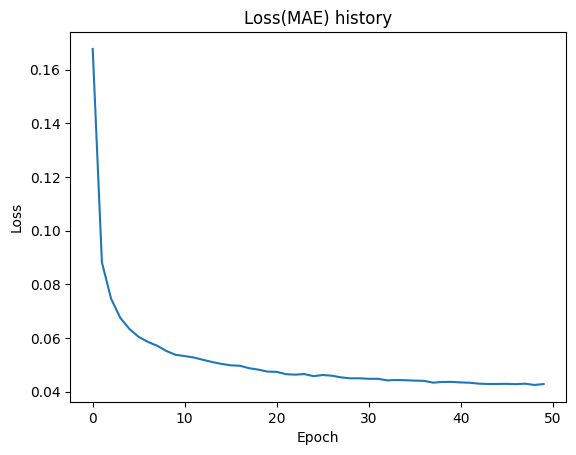

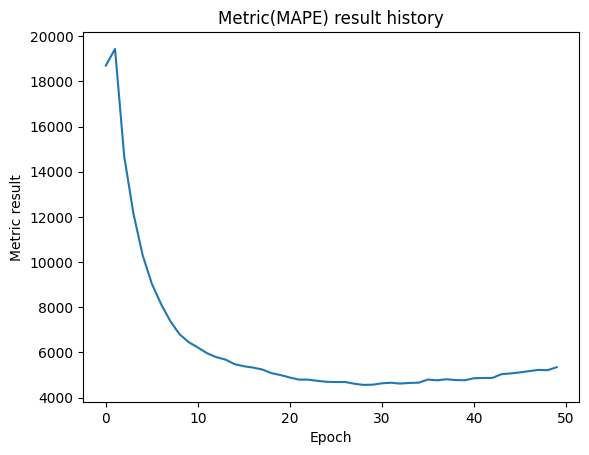

In [ ]:
# Plot the history of loss
plt.plot(range(num_epochs), loss_info_LSTM)
plt.title('Loss(MAE) history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the history of metric result
plt.plot(range(num_epochs), metric_info_LSTM)
plt.title('Metric(MAPE) result history')
plt.xlabel('Epoch')
plt.ylabel('Metric result')
plt.show()

In [ ]:
# Testing model's performance on our dataset
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [ ]:
running_loss = 0.0                                             # MAE Loss
running_metric = 0.0                                           # MAPE metric

batch_size = 1
modPred_LSTM = []
GroundTruth = []
for i in tqdm(range(0, len(x_test_tensor), batch_size), desc=f"Train set inference ..."):
  
        # Get batch of inputs and targets
        batch_x = x_test_tensor[i:i+batch_size]
        batch_y = y_test_tensor[i:i+batch_size]
        
        # Reshape input tensor
        batch_x = batch_x.view(-1, window_length, features)

        # Forward pass
        with torch.inference_mode():
            modelLSTM.eval()
            outputs = modelLSTM(batch_x)

        if batch_size == 1:
            loss = criterion(outputs.view(-1).to(outputs.device), batch_y.to(outputs.device))
            metric = metricc(outputs.view(-1).to(outputs.device), batch_y.to(outputs.device))
            if outputs.view(-1).cpu().detach() < 0:
                modPred_LSTM.append(0)
            else: 
                modPred_LSTM.append(outputs.view(-1).cpu().detach())
            GroundTruth.append(torch.tensor([batch_y]).cpu().detach())
        
        else:
            loss = criterion(outputs.view(-1), batch_y)
            metric = metricc(outputs.view(-1), batch_y)
            if outputs.view(-1).cpu().detach() < 0:
                modPred_LSTM.append(0)
            else: 
                modPred_LSTM.append(outputs.view(-1).cpu().detach())
            GroundTruth.append(batch_y.cpu().detach())
          
        running_loss += loss.item()
        running_metric += metric.item()

test_loss = running_loss / (len(x_train) / batch_size)
test_metric = running_metric / (len(x_train) / batch_size)
print("-"*25, "TEST LOSS", "-"*25)
print(f"Test MAE loss: {test_loss:.9f}")
print(f"Test MAPE metric: {test_metric:.9f}")

Train set inference ...:   0%|          | 0/480 [00:00<?, ?it/s]

------------------------- TEST LOSS -------------------------
Test MAE loss: 0.000486032
Test MAPE metric: 49.389842354


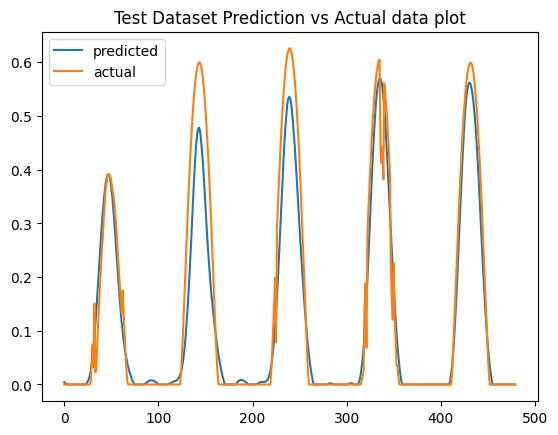

In [ ]:
plt.plot(modPred_LSTM)
plt.plot(GroundTruth)
plt.title('Test Dataset Prediction vs Actual data plot')
plt.legend(['predicted', 'actual'])
plt.show()